# Importa as bibliotecas necessárias

In [2]:
!pip install shapely
!pip install matplotlib
!pip install pandas
!pip install numpy

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Define o arquivo da pista a ser analisada

Nem sempre o nome do arquivo relativo à pista será o mesmo nome dentro do painel da AWS. Para identificar o arquivo correspondente a pista e ao sentido (horário ou anti-horário), basta verificar na tabela no seguinte repositório:

https://github.com/aws-deepracer-community/deepracer-race-data/tree/main/raw_data/tracks

In [3]:
# Nome do arquivo da pista
track_name = "2022_march_pro_cw.npy"
# Caminho para a pasta de pistas
waypoints = np.load("tracks/%s" % track_name)

In [4]:
waypoints[0]

array([ 0.76854774, -0.39787646,  0.81247423,  0.13372864,  0.72462129,
       -0.92948104])

In [5]:
# Get number of waypoints
print("Number of waypoints = " + str(waypoints.shape[0]))

Number of waypoints = 258


In [6]:
#Separa os pontos relativos a cada parte da pista

center_line = waypoints[:,0:2] #linha central
inner_border = waypoints[:,2:4] #contorno interno
outer_border = waypoints[:,4:6] #contorno externo

In [7]:
# Converte esses pontos para objetos shapely (linha)

l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)

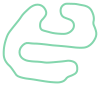

In [8]:
l_center_line

# Analise visual da pista

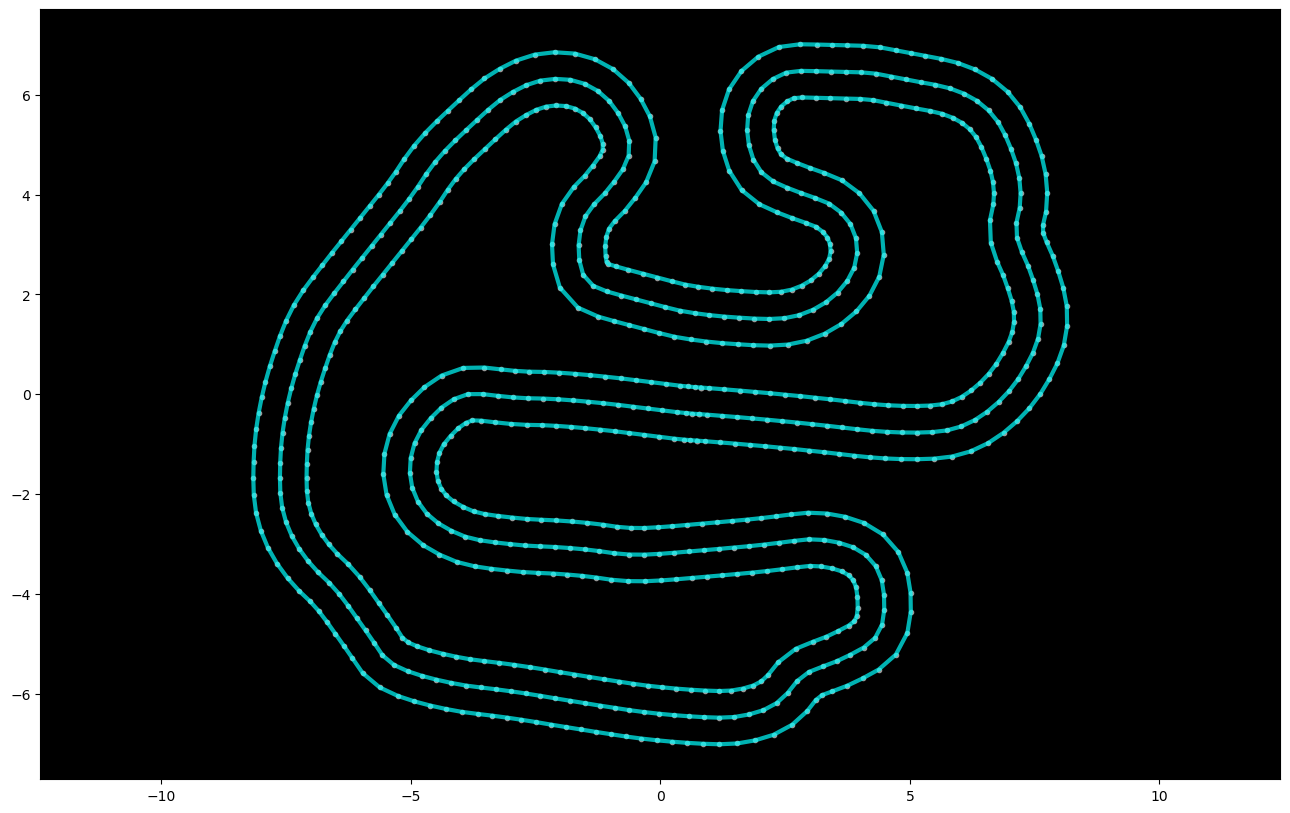

In [9]:
#Plota a pista composta por seus waypoints

def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)


# Ajuste manual dos pontos de velocidade

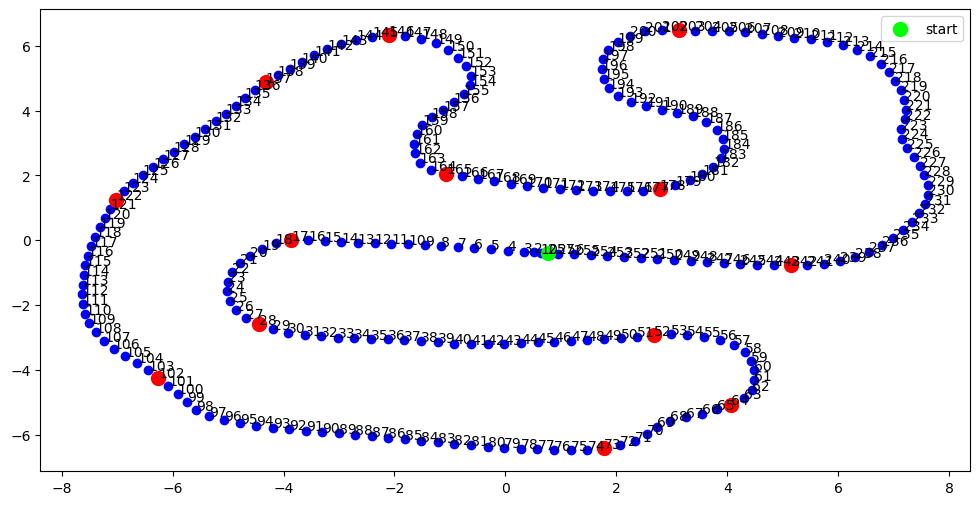

In [19]:
# Definimos manualmente os waypoints relativos a cada velocidade da pista

ax = fig.add_subplot(111)
plt.figure(figsize=(12, 6))

for i, point in enumerate(waypoints): #Desenha a pista a partir dos waypoints
    plt.scatter(point[0], point[1], color='blue')
#     plt.scatter(point[2], point[3], color='black')
#     plt.scatter(point[4], point[5], color='black')
    
    plt.annotate(i, (point[0], point[1])) #Coloca o texto relativo ao número de cada waypoint  

plt.scatter(center_line[0][0], center_line[0][1], color='lime', s=100, label="start")

speed_change_points = [17, 28, 52, 64, 73, 102, 122, 137, 146, 165, 178, 203, 242] #Define manualmente os pontos de alteração de velocidade

for s in speed_change_points:
    plt.scatter(center_line[s][0], center_line[s][1], color='red', s=100)

plt.legend()
plt.show()

# Analise do mapa de velocidade da pista

In [27]:
# A partir do processo anterior, criamos agora os trechos de velocidade passando os intervalos na lista abaixo
[17, 28, 52, 64, 73, 102, 122, 137, 146, 165, 178, 203, 242]
fast = [(0, 16), (28, 51), (73, 101), (122, 135), (242, 258)]
medium = [(64, 72), (102, 121), (136, 145), (165, 177), (203, 241)]
slow = [(17, 27), (52, 63), (146, 164), (178, 202)]

data = []

for point in range(waypoints.shape[0]):  # Assuming you have points from 0 to 229
    label = None

    for range_start, range_end in fast:
        if range_start <= point <= range_end:
            label = 'fast'
            break

    if label is None:
        for range_start, range_end in medium:
            if range_start <= point <= range_end:
                label = 'medium'
                break

    if label is None:
        for range_start, range_end in slow:
            if range_start <= point <= range_end:
                label = 'slow'
                break

    data.append((point, label))

# Cria um dataframe a partir dos dados de velocidade gerados acima
df = pd.DataFrame(data, columns=['Waypoint', 'Speed'])

# Define a coluna de "Waypoint" como index do df
df.set_index('Waypoint', inplace=True)

df

,Speed
Waypoint,
0,fast
1,fast
2,fast
3,fast
4,fast
...,...
253,fast
254,fast
255,fast


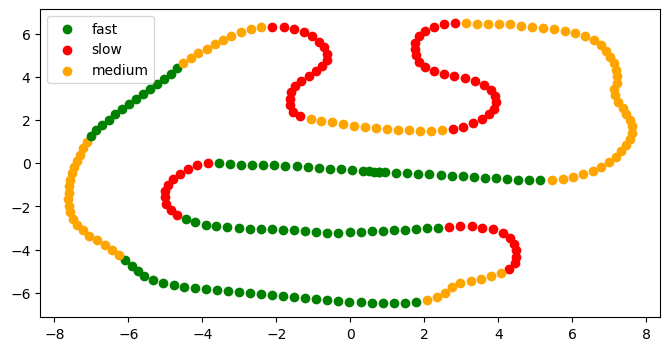

In [28]:
# Mostra o mapa de velocidade para a linha central da pista

plt.figure(1, figsize=(8, 4))

for i in range(waypoints.shape[0]):
    speed = df.loc[i]['Speed']

    color = "grey"
    if speed == 'fast':
        color = 'green'
    elif speed == 'medium':
        color = 'orange'
    elif speed == 'slow':
        color = 'red'
    plt.scatter(waypoints[i][0], waypoints[i][1], color=color, label=speed)
    #plt.scatter(waypoints[i][2], waypoints[i][3], color='black')
    #plt.scatter(waypoints[i][4], waypoints[i][5], color='black')


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [29]:
# Gera a lista de waypoints de cada velocidade para ser usada na função de recompensa
from pprint import pprint

waypoints_list = {
    'fast': [],
    'medium': [],
    'slow': []
}


for i in range(waypoints.shape[0]):
    speed = df.loc[i]['Speed']
    waypoints_list[speed].append(i)


print(f'fast = {waypoints_list["fast"]}\n')
print(f'medium = {waypoints_list["medium"]}\n')
print(f'slow = {waypoints_list["slow"]}\n')

fast = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257]

medium = [64, 65, 66, 67, 68, 69, 70, 71, 72, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241]

slow = [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 146, 147, 14